# Analyzing the standard DataFrames

In [7]:
import sys
import logging
from pathlib import Path
logger = logging.getLogger('gutils')
logger.handlers = [logging.StreamHandler()]
logger.setLevel(logging.DEBUG)


here = str(Path('.').absolute().parent.parent)
if here not in sys.path:
    sys.path.append(here)
sys.path

['',
 '/data/conda/miniconda3-py36/envs/gutils36/lib/python36.zip',
 '/data/conda/miniconda3-py36/envs/gutils36/lib/python3.6',
 '/data/conda/miniconda3-py36/envs/gutils36/lib/python3.6/lib-dynload',
 '/data/conda/miniconda3-py36/envs/gutils36/lib/python3.6/site-packages',
 '/data/conda/miniconda3-py36/envs/gutils36/lib/python3.6/site-packages/cycler-0.10.0-py3.6.egg',
 '/data/conda/miniconda3-py36/envs/gutils36/lib/python3.6/site-packages/pytest_cache-1.0-py3.6.egg',
 '/data/conda/miniconda3-py36/envs/gutils36/lib/python3.6/site-packages/IPython/extensions',
 '/home/kwilcox/.ipython',
 '/data/dev/GUTILS']

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mpd
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_rows', 12)
sns.set()
sns.set_context(context="notebook", font_scale=1.1)

### Load a DataFrame of standardized data

In [9]:
from pathlib import Path
from gutils.slocum import SlocumReader

ascii_folder = Path('.').absolute().parent.parent / 'gutils' / 'tests' / 'resources' / 'slocum' / 'bass-test-ascii' / 'rt' / 'ascii'
ascii_file = ascii_folder / 'usf_bass_2016_252_1_12_sbd.dat'
#slocum_data = SlocumReader(str(ascii_file))
slocum_data = SlocumReader('/home/kwilcox/Downloads/test_data_gtuils/test_data/ascii2/otn200_2017_349_7_100_dbd.dat')
standard = slocum_data.standardize()
standard[[
    't',
    'y',
    'x',
    'pressure'
]]

,t,y,x,pressure
0,2017-12-23 14:08:42.247590065,43.068318,-65.280482,0.0
1,2017-12-23 14:08:46.245669842,43.068318,-65.280482,NaN
2,2017-12-23 14:08:46.245669842,43.068318,-65.280482,NaN
3,2017-12-23 14:08:48.031399965,43.068318,-65.280611,NaN
4,2017-12-23 14:08:49.036769867,43.068319,-65.280675,NaN
5,2017-12-23 14:08:51.045900106,43.068319,-65.280804,NaN
...,...,...,...,...
11153,2017-12-23 17:56:20.343410015,43.033830,-65.296273,NaN
11154,2017-12-23 17:56:26.181269884,43.033830,-65.296273,NaN
11155,2017-12-23 17:56:30.487000227,43.033830,-65.296273,NaN


## Assign profiles

In [27]:
from gutils.filters import default_filter

def profile_dataframe(default_df, tsint):
    profiled = assign_profiles(default_df, tsint=tsint)
    filtered, _ = default_filter(profiled)
    plot_profiles(filtered, tsint)

    
def plot_profiles(df, tsint):    
    plt.figure(figsize=(14, 8))
    sns.lineplot(
        data=df,
        y='z',
        x='t',
        hue='profile',
        palette="tab20",
        linewidth=2.5,
        legend='full',
        sort=False
    )
    plt.gca().invert_yaxis()
    plt.ylabel('Depth (m_')
    plt.title('Glider depth vs time with {} unique profiles'.format(len(df.profile.unique())))
    plt.tight_layout()

In [28]:
from gutils.yo import assign_profiles


# from gutils import (
#     masked_epoch,
#     boxcar_smooth_dataset
# )

# def calculate_delta_depth(interp_data):
#     """ Figure out when the interpolated Z data turns a corner
#     """
#     delta_depth = np.diff(interp_data) 
#     delta_depth[delta_depth <= 0] = -1
#     delta_depth[delta_depth >= 0] = 1
#     delta_depth = boxcar_smooth_dataset(delta_depth, 2)
#     delta_depth[delta_depth <= 0] = -1
#     delta_depth[delta_depth >= 0] = 1
#     return delta_depth


# def assign_profiles(df, tsint=1):
#     profile_df = df.copy()
#     profile_df['profile'] = np.nan  # Fill profile with nans
#     tmp_df = df.copy()

#     if tsint is None:
#         tsint = 1

#     # Make 't' epochs and not a DateTimeIndex
#     tmp_df['t'] = masked_epoch(tmp_df.t)
#     # Set negative depth values to NaN
#     tmp_df.loc[tmp_df.z <= 0, 'z'] = np.nan

#     # Remove any rows where time or z is NaN
#     tmp_df = tmp_df.dropna(subset=['t', 'z'], how='any')

#     if len(tmp_df) < 2:
#         return None

#     # Create the fixed timestamp array from the min timestamp to the max timestamp
#     # spaced by tsint intervals
#     ts = np.arange(tmp_df.t.min(), tmp_df.t.max(), tsint)
#     # Stretch estimated values for interpolation to span entire dataset
#     interp_z = np.interp(
#         ts,
#         tmp_df.t,
#         tmp_df.z,
#         left=tmp_df.z.iloc[0],
#         right=tmp_df.z.iloc[-1]
#     )
    
#     del tmp_df

#     if len(interp_z) < 2:
#         return None

#     filtered_z = boxcar_smooth_dataset(interp_z, max(tsint // 2, 1))
#     delta_depth = calculate_delta_depth(filtered_z)

#     # Find where the depth indexes (-1 and 1) flip
#     inflections = np.where(np.diff(delta_depth) != 0)[0]
#     # Do we have any profiles?
#     if inflections.size < 1:
#         return profile_df

#     # Prepend a zero at the beginning start the series of profiles
#     p_inds = np.insert(inflections, 0, 0)
#     # Append the size of the time array to end the series of profiles
#     p_inds = np.append(p_inds, ts.size - 1)
#     # Zip up neighbors to get the ranges of each profile in interpolated space
#     p_inds = list(zip(p_inds[0:-1], p_inds[1:]))
#     # Convert the profile indexes into datetime objets
#     p_inds = [
#         (
#             pd.to_datetime(ts[int(p0)], unit='s'),
#             pd.to_datetime(ts[int(p1)], unit='s')
#         )
#         for p0, p1 in p_inds
#     ]
    
#     # We have the profiles in interpolated space, now associate this
#     # space with the actual data using the datetimes.
    
#     # Iterate through the profile start/stop indices
#     for profile_index, (min_time, max_time) in enumerate(p_inds):

#         # Get rows between the min and max time
#         time_between = profile_df.t.between(min_time, max_time, inclusive=True)
        
#         # Get indexes of the between rows since we can't assign by the range due to NaT values
#         ixs = profile_df.loc[time_between].index.tolist()

#         # Set the rows profile column to the profile id
#         if len(ixs) > 1:
#             profile_df.loc[ixs[0]:ixs[-1], 'profile'] = profile_index
#         elif len(ixs) == 1:
#             profile_df.loc[ixs[0], 'profile'] = profile_index
#         else:
#             L.debug('No data rows matched the time range of this profile, Skipping.')

#     # Remove rows that were not assigned a profile
#     # profile_df = profile_df.loc[~profile_df.profile.isnull()]

#     return profile_df


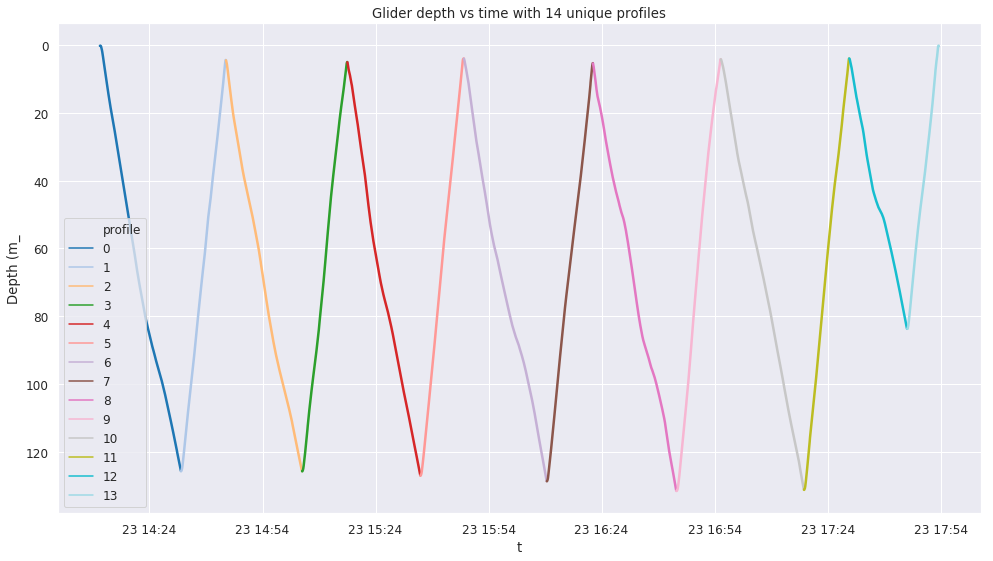

In [29]:
profile_dataframe(standard, 4)

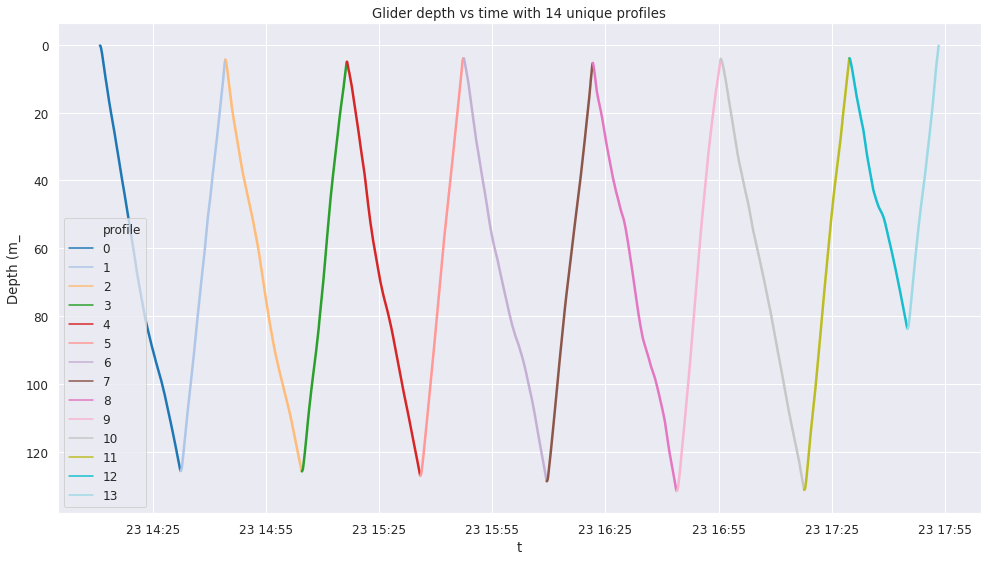

In [30]:
profile_dataframe(standard, 2)

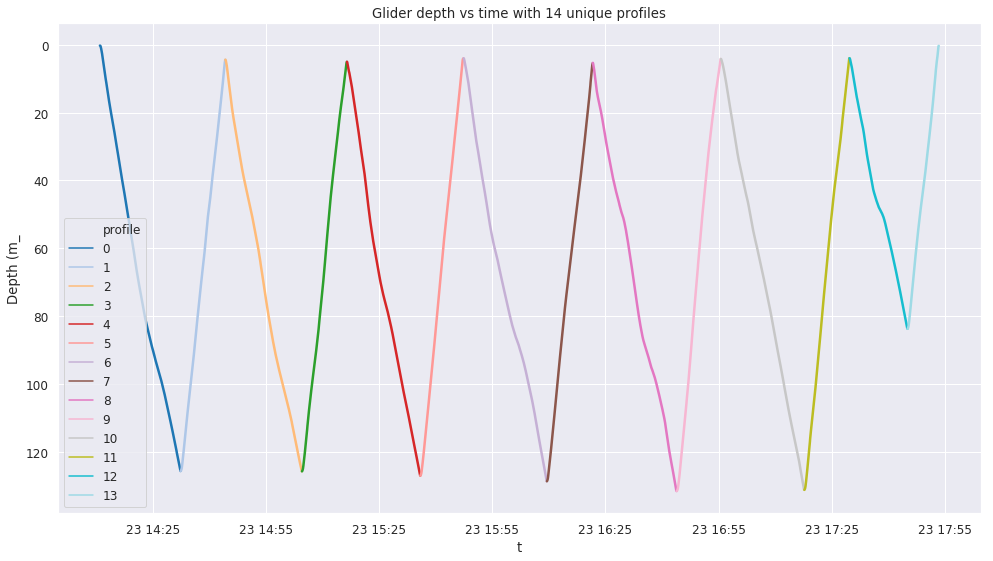

In [31]:
profile_dataframe(standard, 1)